In [0]:
import matplotlib as plt
import seaborn as sn
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st

Configure the length of every generated sequence

In [0]:
iterations = 1000

###Middle part of the square method


Seed needed to start generator

In [0]:
seed = 1931

Random numbers generator function

In [0]:
def random_numbers_generator(seed):
    random_numbers = []
    
    for i in range(iterations):
        random_numbers.append(seed)
        seed = str(seed**2)
        while len(seed) < 8:
            seed = "0" + seed
        seed = int(seed[2:6])
    
    return random_numbers

In [0]:
def map_random_numbers_generator(random_numbers):
   return list(map(lambda x: x / 10000, random_numbers))

Plot of the generator

In [0]:
sn.set()
x = np.arange(0,len(random_numbers_generator(seed)))
#sn.scatterplot(x, random_numbers_generator(seed))
#sn.distplot( random_numbers_generator(seed), bins=10, kde=False)


### General functions and configuration variables for every Linear Congruential Generator

Curried function that returns the following number in the sequence by using the LCG formula

In [0]:
def mixed_congruential_generator(m, a, c):
    def specific_variant(xn):
        return (xn * a + c) % m
    return specific_variant

Function that generates the sequence of pseudo random numbers using an specific LCG 

In [0]:
def generate_random_nums(n_iters, seed, specific_LGC_variant):
    random_nums_list = [(specific_LGC_variant(seed))]
    for i in range(n_iters - 1):
        random_nums_list.append(specific_LGC_variant(random_nums_list[i]))
    return random_nums_list

Function that divide each number by m, so we get numbers ranging from zero to one

In [0]:
def map_sequence_to_uniform_distribution(random_nums,m):
    return list(map(lambda x: x / m, random_nums))

### Specific configurations for each Linear Congruential Generator

Setup the variables required for a custom linear congruential generator

In [0]:
s = 4346345754

In [0]:
m_custom = 2 ** 64
a_custom = 18446744073709551557
c_custom = 0

In [0]:
m_ansi_c =  6075
a_ansi_c =  106
c_ansi_c = 1283

In [0]:
c_randu = 12345
m_randu = 2 ** 48
a_randu = 1103515245

Map sequences to uniform distributions

In [0]:
mapped_random_nums_custom = map_sequence_to_uniform_distribution(
    generate_random_nums(n_iters=iterations, seed=s,specific_LGC_variant=mixed_congruential_generator(m_custom, a_custom, c_custom))
    ,m_custom
)

mapped_random_nums_randu = map_sequence_to_uniform_distribution(
    generate_random_nums(n_iters=iterations, seed=s,specific_LGC_variant=mixed_congruential_generator(m_randu, a_randu, c_randu))
    ,m_randu
)

mapped_random_nums_ansi_c = map_sequence_to_uniform_distribution(
    generate_random_nums(n_iters=iterations, seed=s,specific_LGC_variant=mixed_congruential_generator(m_ansi_c, a_ansi_c, c_ansi_c))
    ,m_ansi_c
)

uniform_mersenne_twister = np.random.uniform(size=iterations)

mapped_random_nums_middle_square = map_random_numbers_generator(
    random_numbers_generator(seed)
)

Show distributions

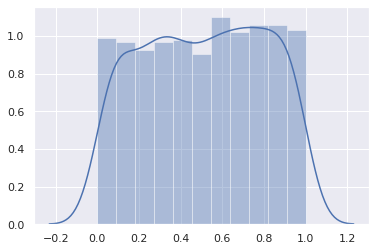

In [0]:
sn.distplot(mapped_random_nums_custom)

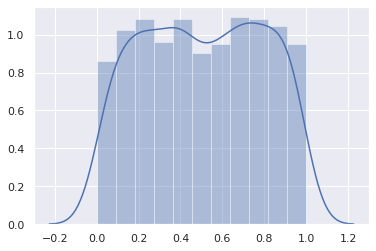

In [0]:
sn.distplot(mapped_random_nums_ansi_c)

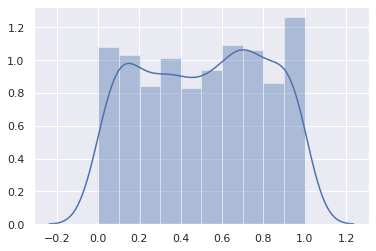

In [0]:
sn.distplot(mapped_random_nums_randu)

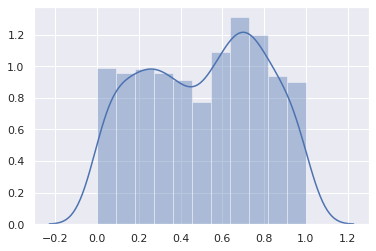

In [0]:
sn.distplot(uniform_mersenne_twister)

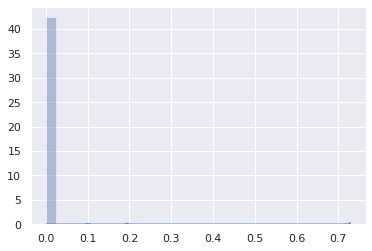

In [0]:
sn.distplot(mapped_random_nums_middle_square)

Autocorrelation test

In [0]:
def autocorrelation_test(series, significance_level):
  index = 2
  amplitude = 5
  acum = 0
  M = int(np.trunc((len(series)-index)/amplitude) - 1)

  for k in range(M + 1):
    first = series[index+k*amplitude]
    second = series[index + amplitude * (k + 1)]
    acum += first * second

  dp = acum * (1/(M+1)) 

  dp_std = np.sqrt(13*M+7)/(12*(M+1))
  
  z_empirical = (dp - 0.25) / dp_std
  print(z_empirical)
  z_theoretical = st.norm.ppf(1 - significance_level/2)
  

  return -z_theoretical <= z_empirical <= z_theoretical


Chi Square test

In [0]:
def chi_square_test(series, significance_level):
  n_bins = 10
  N = series.count()
  observed = series.value_counts(normalize=False, bins=n_bins)
  expected = np.repeat(a=N/n_bins, repeats=n_bins)

  x2 = sum(((observed - expected) ** 2) / expected)
  x2_critic = sp.stats.chi2.ppf(1 - (significance_level / 2), n_bins - 1)

  return x2 < x2_critic

KS test



In [0]:
def ks_test(series, significance_level):
  indexed_sorted_series = list(zip(np.arange(1000), series.sort_values()))
  n = series.count()

  D_plus = max([abs((i / n) - fx) for i, fx in indexed_sorted_series])
  D_minus = max([abs(fx - ((i - 1) / n)) for i, fx in indexed_sorted_series])

  D = max(D_plus, D_minus)
  print(D)
  D_critic = sp.stats.ksone.ppf(1 - (significance_level / 2), n)

  return D < D_critic

Runs above and below mean test

In [0]:
sp.stats.norm.ppf(0.025)

-1.9599639845400545

In [0]:
def get_runs(boolean_mask):
  b = 0 
  last = None
  for x in boolean_mask:
    if (x != last):
      b += 1
    last = x
  
  return b

In [0]:
def runs_above_and_below_mean_test(series, significance_level):
  mean = series.mean()
  N = series.count()
  n1 = series[lambda x: x >= mean].count() # above mean
  n2 = series[lambda x: x < mean].count() # below mean

  if n2 <= 20: 
    return False

  b = get_runs(series.gt(mean))

  b_mean = ((2 * n1 * n2) / N) + (1 / 2)
  b_var = (2 * n1 * n2 * (2 * n1 * n2 - N)) / ((N ** 2) * (N - 1))
  b_std = b_var ** (1/2)
  
  Z = (b - b_mean) / b_std
  print(Z)
  Z_critic = sp.stats.norm.ppf(1 - (significance_level / 2))

  return -Z_critic <= Z <= Z_critic


Setup series

In [0]:
distributions_to_test = ["LCG Custom", "LCG Randu", "LCG Ansi C", "Mersenne Twister", "Middle Square"]

In [0]:
tests = ["Chi Square", "KS", "Autocorrelation" ,"Runs"]

In [0]:
lcg_custom = pd.Series(mapped_random_nums_custom)
lcg_randu  = pd.Series(mapped_random_nums_randu)
lcg_ansi_c  = pd.Series(mapped_random_nums_ansi_c)
uniform = pd.Series(uniform_mersenne_twister)
middle_square = pd.Series(mapped_random_nums_middle_square)

Chi square test results

In [0]:
chi_square_tests = [
  chi_square_test(lcg_custom, significance_level=0.05),
  chi_square_test(lcg_ansi_c, significance_level=0.05),
  chi_square_test(lcg_randu, significance_level=0.05),
  chi_square_test(uniform, significance_level=0.05),
  chi_square_test(middle_square,significance_level=0.05)
]

KS test results

In [0]:
ks_tests = [
  ks_test(lcg_custom, significance_level=0.05),
  ks_test(lcg_ansi_c, significance_level=0.05),
  ks_test(lcg_randu, significance_level=0.05),
  ks_test(uniform, significance_level=0.05),
  ks_test(middle_square, significance_level=0.05)
]

0.02716001523827971
0.021567901234567893
0.0378483241292088
0.014070764667540758
0.9929


Autocorrelation test results

In [0]:
autocorrelation_tests = [
  autocorrelation_test(lcg_custom, significance_level=0.05),
  autocorrelation_test(lcg_ansi_c, significance_level=0.05),
  autocorrelation_test(lcg_randu, significance_level=0.05),
  autocorrelation_test(uniform, significance_level=0.05),
  autocorrelation_test(middle_square, significance_level=0.05)
]

1.1194525177401697
0.9763702578270428
2.861113916492277
1.3283965795543637
-11.75114888824592


Runs above and below mean test results

In [0]:
runs_above_and_below_mean_tests = [
  runs_above_and_below_mean_test(lcg_custom, significance_level=0.05),
  runs_above_and_below_mean_test(lcg_ansi_c, significance_level=0.05),
  runs_above_and_below_mean_test(lcg_randu, significance_level=0.05),
  runs_above_and_below_mean_test(uniform, significance_level=0.05),
  runs_above_and_below_mean_test(middle_square,significance_level=0.05)
]

-1.285042329781275
0.2867907857918171
0.8672453161578051
-1.1029545737697355
-28.868858259554706


In [0]:
pd.DataFrame(data=[chi_square_tests, ks_tests, autocorrelation_tests, runs_above_and_below_mean_tests], columns=distributions_to_test, index=tests)

,LCG Custom,LCG Randu,LCG Ansi C,Mersenne Twister,Middle Square
Chi Square,True,True,True,True,False
KS,True,True,True,True,False
Autocorrelation,True,True,False,True,False
Runs,True,True,True,True,False
